In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.5 MB/s eta 0:00:00


In [ ]:
# Força reinstalação do PyTorch sem conflitos extras
!pip uninstall -y torch torchvision torchaudio torch-decomp
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm pywt


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 132.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account al

In [ ]:
import numpy as np
import pandas as pd
import pywt
from tqdm import tqdm
import os
from google.colab import drive, files

In [ ]:
# Parâmetros principais
Fs = 5000
A = 1
f_min = 1
cycles_to_capture = 3
t_end = cycles_to_capture / f_min
t = np.arange(0, t_end, 1 / Fs)
T = t[-1]
w = 2 * np.pi * f_min

snr_options = [10, 20, 30]
num_signals = 1600000

# Caminho para salvar os arquivos
output_dir = "output_csv"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# AWGN com SNR aleatório
def awgn(signal, SNRdB):
    sigma = np.sqrt(np.var(signal) / (10**(SNRdB / 10)))
    noise = sigma * np.random.randn(len(signal))
    return signal + noise

# Decomposição Wavelet
def wavelet_decomposition(signal, level=6):
    wp = pywt.WaveletPacket(signal, wavelet='db6', mode='symmetric', maxlevel=level)
    return wp

# Extração de características
def features(wp):
    nodes = wp.get_level(wp.maxlevel, 'natural')
    features_list = []
    for node in nodes:
        data = node.data
        energy = np.sum(data**2)
        relative_energy = energy / len(data)
        entropy = -np.sum(data * np.log2(np.abs(data) + 1e-10))
        std_dev = np.std(data)
        rms_value = np.sqrt(np.mean(data**2))
        max_value = np.max(np.abs(data))
        crest_factor = max_value / rms_value if rms_value != 0 else 0
        mean_value = np.mean(data)
        power = np.mean(data**2)
        features_list.extend([energy, relative_energy, entropy, std_dev, crest_factor, mean_value, power])
    return features_list

# Funções geradoras de sinais (sem alterações)

def u(x):
    return np.where(x >= 0, 1, 0)

def generate_normal():
    return A * np.sin(50 * np.pi * t)

def generate_voltage_sag():
    t1, t2 = 1.5, 3.5
    a = 0.8
    return A * (1 - a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t)

def generate_voltage_swell():
    t1, t2 = 1.5, 3.5
    a = 0.8
    return A * (1 + a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t)

def generate_harmonics():
    a1, a3, a5, a7, a9 = 1, 0.1, 0.2, 0.25, 0.3
    return A * (a1 * np.sin(2 * np.pi * t) + a3 * np.sin(6 * np.pi * t) + a5 * np.sin(10 * np.pi * t) + a7 * np.sin(14 * np.pi * t) + a9 * np.sin(18 * np.pi * t))

def generate_flicker():
    af, bf = 0.2, 15
    return A * (1 + af * np.sin(bf * 2 * np.pi * t)) * np.sin(2 * np.pi * t)

def generate_oscillatory_transient():
    b, t1 = 2, 2.5
    return A * (np.sin(2 * np.pi * t) + b - np.where(t > t1, np.sin(10 * np.pi * t), 0))

def generate_sag_with_harmonics():
    t1, t2 = 1.5, 3.5
    a = 0.8
    base = generate_harmonics()
    return A * (1 - a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t) * base

def generate_swell_with_harmonics():
    t1, t2 = 1.5, 3.5
    a = 0.8
    base = generate_harmonics()
    return A * (1 + a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t) * base

def generate_interruption():
    a, t1, t2 = 0.88, 1.5, 3.5
    return A * (1 - a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t)

def generate_interruption_with_harmonics():
    a, t1, t2 = 0.88, 1.5, 3.5
    base = generate_harmonics()
    return A * (1 - a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t) * base

def generate_impulsive_transient():
    alpha = 0.1
    t1 = T / 20
    t2 = T / 10
    return A * (1 - alpha * u(t - t1) - u(t - t2)) * np.sin(w * t)

def generate_periodic_notch():
    K = 0.3
    return np.sin(2 * np.pi * t) - np.sign(np.sin(2 * np.pi * t)) * K * u(t - 2)

def generate_flicker_with_harmonics():
    af, bf = 0.2, 15
    base = generate_harmonics()
    return A * (1 + af * np.sin(bf * 2 * np.pi * t)) * np.sin(2 * np.pi * t) * base

def generate_spike():
    K = 0.3
    return np.sin(2 * np.pi * t) + np.sign(np.sin(2 * np.pi * t)) * K * u(t - 2)

def generate_flicker_with_sag():
    af, bf = 0.2, 15
    t1, t2 = 1.5, 3.5
    a = 0.8
    return A * (1 + af * np.sin(bf * 2 * np.pi * t)) * (1 - a * (np.int32(t > t1) - np.int32(t > t2))) * np.sin(4 * np.pi * t)

def generate_flicker_with_swell():
    alpha_f = 0.15
    beta = 10
    alpha = 0.8
    t1 = T
    t2 = 9 * T
    return A * (1 + alpha_f * np.sin(beta * 2 * np.pi * t)) * np.sin(w * t) * (1 + alpha * (u(t - t1) - u(t - t2)))

# Lista de funções
signal_functions = [
    ('Normal', generate_normal),
    ('Voltage_sag', generate_voltage_sag),
    ('Voltage_swell', generate_voltage_swell),
    ('Harmonics', generate_harmonics),
    ('Flicker', generate_flicker),
    ('Oscillatory_transient', generate_oscillatory_transient),
    ('Sag_harmonics', generate_sag_with_harmonics),
    ('Swell_harmonics', generate_swell_with_harmonics),
    ('Interruption', generate_interruption),
    ('Interruption_with_harmonics', generate_interruption_with_harmonics),
    ('Impulsive_transient', generate_impulsive_transient),
    ('Periodic_notch', generate_periodic_notch),
    ('Flicker_with_harmonics', generate_flicker_with_harmonics),
    ('Spike', generate_spike),
    ('Flicker_with_sag', generate_flicker_with_sag),
    ('Flicker_with_swell', generate_flicker_with_swell),
]

# Geração de colunas
sample_wp = wavelet_decomposition(awgn(signal_functions[0][1](), 20))
nodes = sample_wp.get_level(sample_wp.maxlevel, 'natural')
columns = []
for i in range(len(nodes)):
    columns += [f'Node_{i:03d}_energy', f'Node_{i:03d}_relative_energy', f'Node_{i:03d}_entropy',
                f'Node_{i:03d}_std_dev', f'Node_{i:03d}_crest_factor', f'Node_{i:03d}_mean_value', f'Node_{i:03d}_power']
columns += ['SNR_dB', 'Label']

# Cálculo automático
total_classes = len(signal_functions)
num_files_total = total_classes  #  Corrigido para garantir pelo menos 1 por classe
files_per_class = max(1, num_files_total // total_classes)
samples_per_file = num_signals // num_files_total

print(f" Gerando {num_files_total} arquivos com {samples_per_file} amostras cada...\n")

# Loop principal
with tqdm(total=num_signals, desc="Processando sinais") as pbar:
    for name, func in signal_functions:
        for file_id in range(files_per_class):
            filename = f"{name}_part{file_id+1}.csv"
            filepath = os.path.join(output_dir, filename)
            rows = []
            for _ in range(samples_per_file):
                try:
                    snr = np.random.choice(snr_options)
                    noisy_signal = awgn(func(), snr)
                    wp = wavelet_decomposition(noisy_signal)
                    feats = features(wp)
                    rows.append(feats + [snr, name])
                    pbar.update(1)
                except Exception as e:
                    print(f" Erro ao processar {name}: {e}")
            pd.DataFrame(rows, columns=columns).to_csv(filepath, index=False, encoding='utf-8', sep=';')
            print(f" Arquivo salvo: {filepath}")

print(f"\n Todos os arquivos CSV foram gerados em: {output_dir}")


🚀 Gerando 16 arquivos com 100000 amostras cada...



Processando sinais:   6%|▋         | 100015/1600000 [14:00<667:21:52,  1.60s/it] 

✅ Arquivo salvo: output_csv/Normal_part1.csv


Processando sinais:  13%|█▎        | 200001/1600000 [28:14<823:46:39,  2.12s/it]

✅ Arquivo salvo: output_csv/Voltage_sag_part1.csv


Processando sinais:  19%|█▉        | 300001/1600000 [42:28<858:01:32,  2.38s/it]

✅ Arquivo salvo: output_csv/Voltage_swell_part1.csv


Processando sinais:  25%|██▌       | 400001/1600000 [58:26<1031:37:05,  3.09s/it]

✅ Arquivo salvo: output_csv/Harmonics_part1.csv


Processando sinais:  31%|███▏      | 500001/1600000 [1:13:02<732:59:35,  2.40s/it]

✅ Arquivo salvo: output_csv/Flicker_part1.csv


Processando sinais:  38%|███▊      | 600001/1600000 [1:27:37<561:52:42,  2.02s/it]

✅ Arquivo salvo: output_csv/Oscillatory_transient_part1.csv


Processando sinais:  40%|███▉      | 639776/1600000 [1:33:30<2:20:21, 114.01it/s]

In [ ]:
# arquivo 01 - UNIFICADOR

from google.colab import drive
import os
import shutil
from glob import glob
import pandas as pd

# 1. Montar o Google Drive
drive.mount('/content/drive')

# 2. Caminhos
local_output_dir = "output_csv"  # Pasta local onde os CSVs estão
drive_output_dir = "/content/drive/MyDrive/sinais_features01_csv"  # Pasta no Drive
unified_filename = "dataset_sinais.csv"
unified_path_local = os.path.join(local_output_dir, unified_filename)
unified_path_drive = os.path.join(drive_output_dir, unified_filename)

# 3. Criar a pasta no Drive, se não existir
if not os.path.exists(drive_output_dir):
    os.makedirs(drive_output_dir)
    print(f" Pasta criada no Google Drive: {drive_output_dir}")
else:
    print(f" Pasta já existe no Google Drive: {drive_output_dir}")

# 4. Listar arquivos .csv da pasta local (menos o final unificado)
csv_files = [f for f in glob(os.path.join(local_output_dir, "*.csv")) if not f.endswith(unified_filename)]

# 5. Unificar todos os arquivos CSV em um único DataFrame
if len(csv_files) == 0:
    print(" Nenhum arquivo CSV encontrado na pasta local.")
else:
    print(f" Unificando {len(csv_files)} arquivos...")
    df_list = [pd.read_csv(f, sep=';') for f in csv_files]
    df_merged = pd.concat(df_list, ignore_index=True)

    # Colocar 'Label' como primeira coluna
    if 'Label' in df_merged.columns:
        cols = df_merged.columns.tolist()
        cols.insert(0, cols.pop(cols.index('Label')))
        df_merged = df_merged[cols]

    # 6. Salvar arquivo unificado localmente
    df_merged.to_csv(unified_path_local, index=False, sep=';', encoding='utf-8')
    print(f" Arquivo unificado salvo em: {unified_path_local}")

    # 7. Copiar arquivo final para o Google Drive
    shutil.copy(unified_path_local, unified_path_drive)
    print(f" Arquivo copiado para o Google Drive: {unified_path_drive}")

print("\n Processo de unificação e envio concluído com sucesso!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Pasta criada no Google Drive: /content/drive/MyDrive/sinais_features01_csv
🔄 Unificando 16 arquivos...
✅ Arquivo unificado salvo em: output_csv/dataset_sinais.csv
📤 Arquivo copiado para o Google Drive: /content/drive/MyDrive/sinais_features01_csv/dataset_sinais.csv

🚀 Processo de unificação e envio concluído com sucesso!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


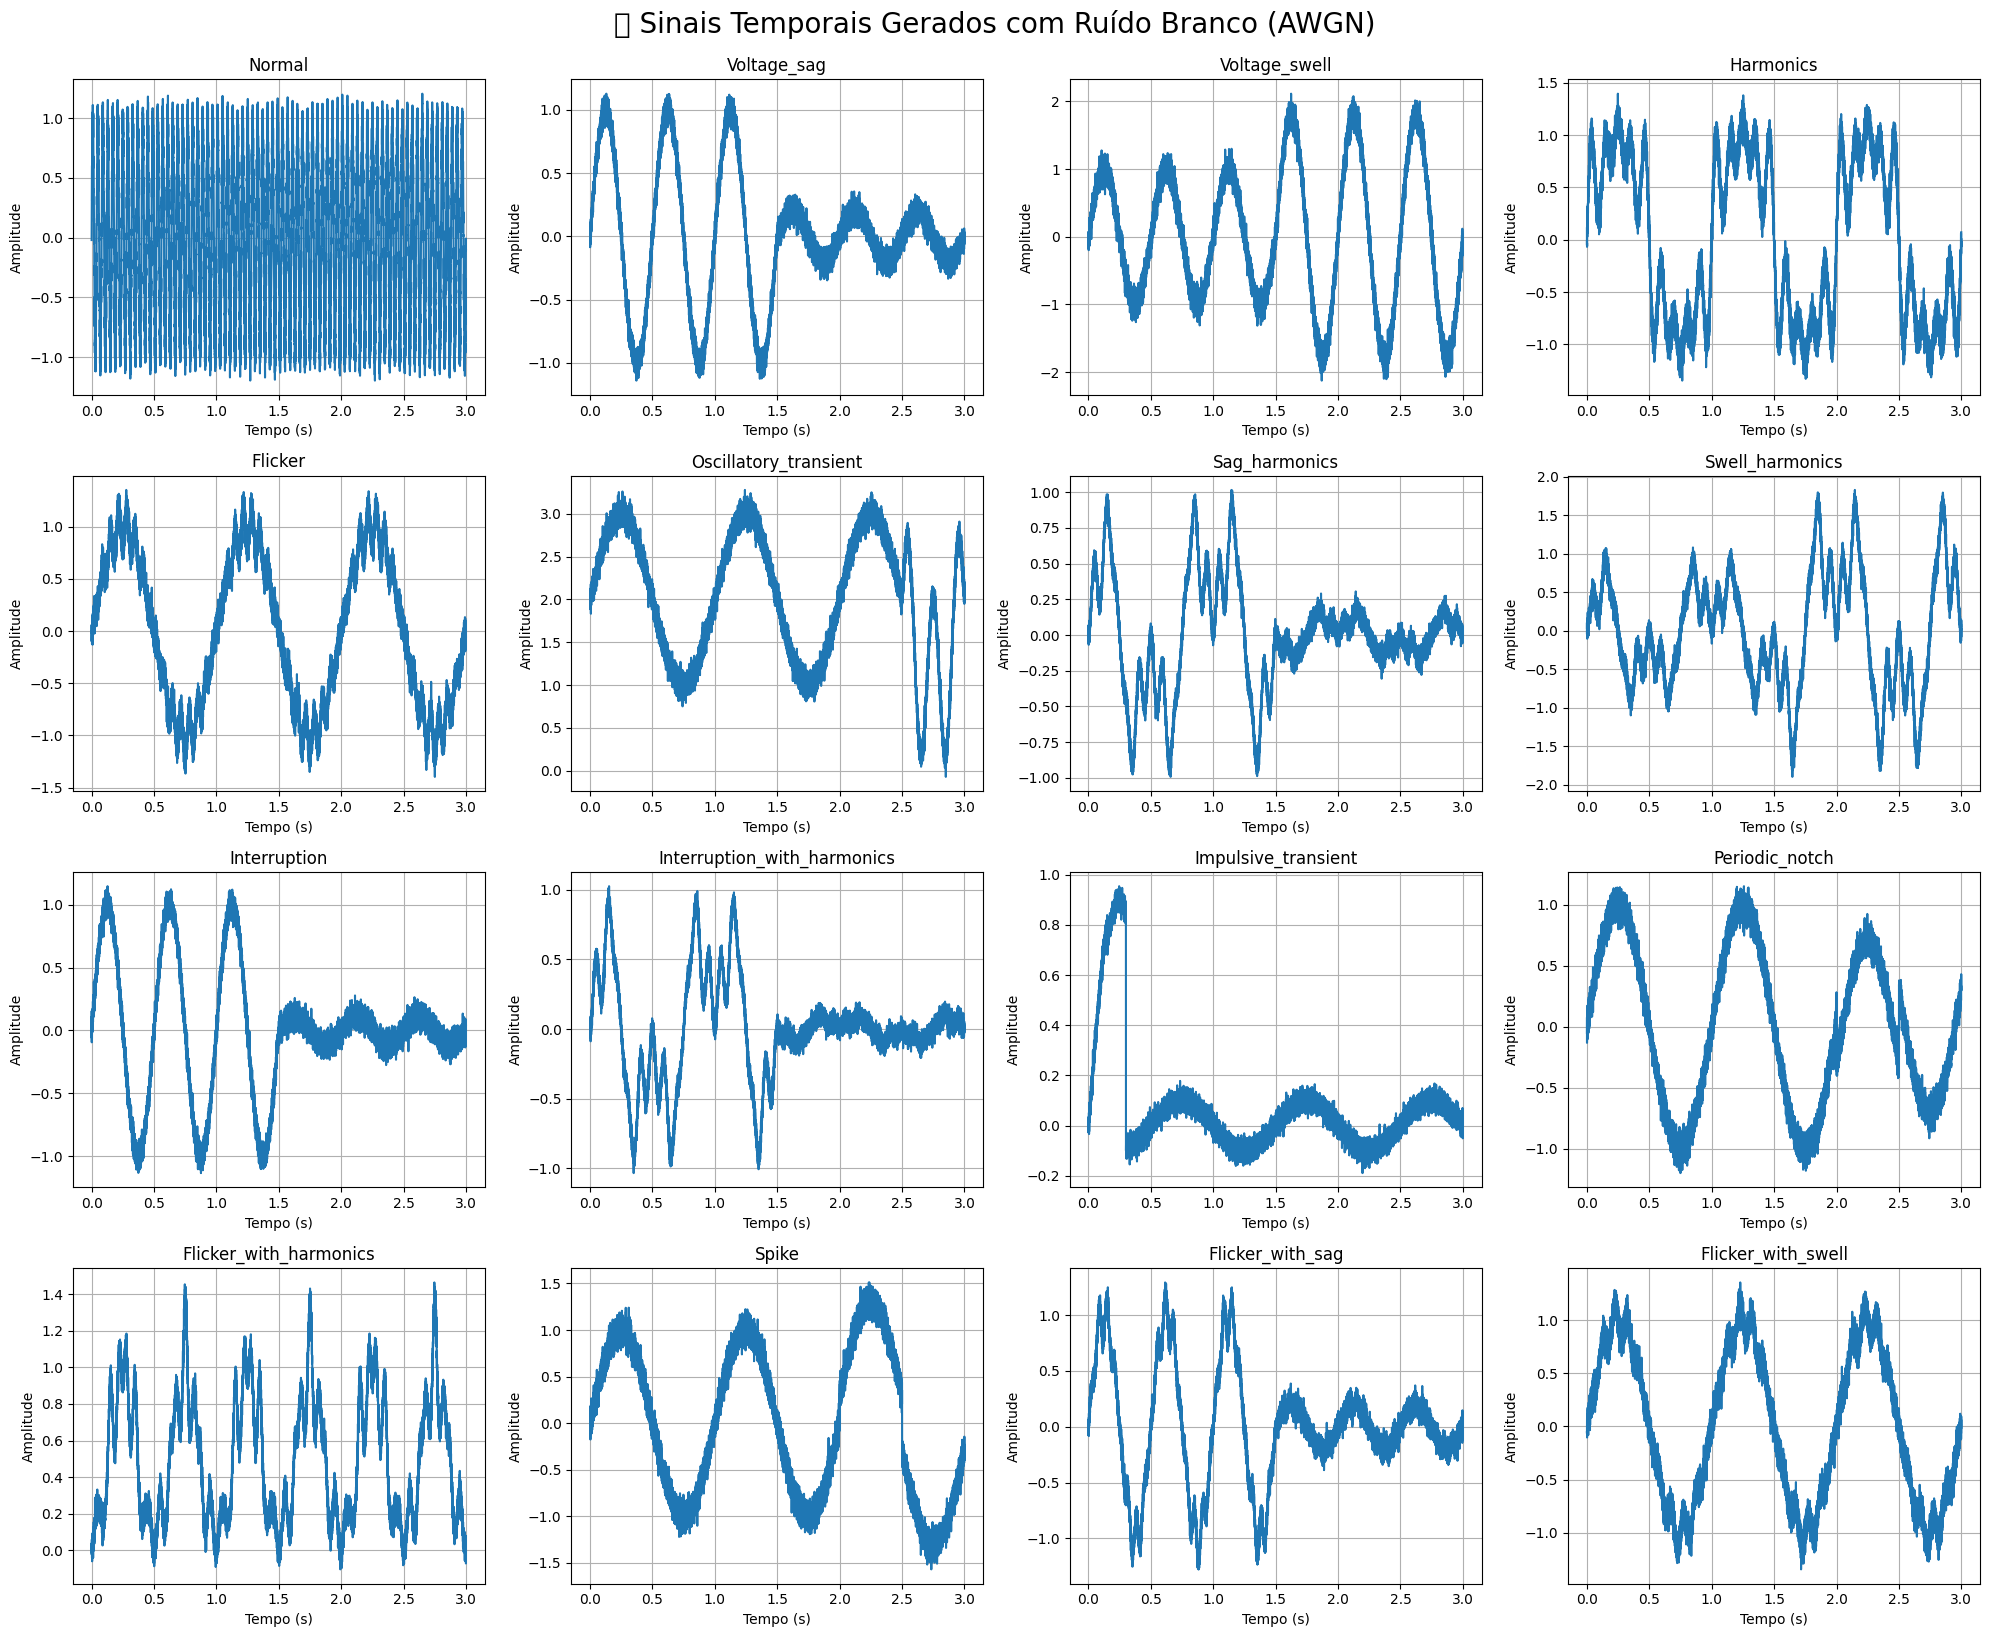

In [ ]:
import matplotlib.pyplot as plt

# Parâmetros para visualização
num_signals_to_plot = 1  # número de exemplos por tipo (você pode aumentar)
SNRdB = 20               # nível de ruído

plt.figure(figsize=(20, 16))

# Gerar e plotar um sinal por tipo
for i, (label, func) in enumerate(signal_functions):
    signal = awgn(func(), SNRdB)  # gera sinal com ruído
    plt.subplot(4, 4, i + 1)
    plt.plot(t, signal)
    plt.title(label)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.suptitle(" Sinais Temporais Gerados com Ruído Branco (AWGN)", fontsize=20, y=1.02)
plt.show()
